In [2]:
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pickle

# DIR_NAME = "20250730_171659-plasma_flower"
DIR_NAME = "20250729_142821-spectra_flower"
IMG_SIZE = 1024
MAX_WIDTH = 16.0
LINSPACE_POINTS = 5

with open(f'results/{DIR_NAME}/shapes.pkl', 'rb') as f:
    shapes = pickle.load(f)

with open(f'results/{DIR_NAME}/shape_groups.pkl', 'rb') as f:
    shape_groups = pickle.load(f)

In [22]:
def bezier_curve(P0, P1, P2, t):
    """Quadratic Bezier curve."""
    return (1 - t) ** 2 * P0 + 2 * (1 - t) * t * P1 + t ** 2 * P2

def cubic_bezier_curve(P0, P1, P2, P3, t):
    """Cubic Bezier curve."""
    return (1 - t) ** 3 * P0 + 3 * (1 - t) ** 2 * t * P1 + 3 * (1 - t) * t ** 2 * P2 + t ** 3 * P3

diffvg_strokes = []
for i in range(len(shapes)):
    s = shapes[i].points.detach().cpu().numpy()
    stroke_width = shapes[i].stroke_width.detach().cpu().numpy()
    num_control_points = shapes[i].num_control_points.detach().cpu().numpy()
    color = shape_groups[i].stroke_color.detach().cpu().numpy()
    r, g, b, a = color

    pts = []
    idx = 0
    for seg in range(len(num_control_points)):
        n_ctrl = num_control_points[seg]
        if n_ctrl == 0:
            p0, p1 = s[idx:idx+2]
            pts.append(np.stack([p0, p1]))
            idx += 1
        elif n_ctrl == 1:
            p0, p1, p2 = s[idx:idx+3]
            t = np.linspace(0, 1, LINSPACE_POINTS)
            pts.append(bezier_curve(p0, p1, p2, t[:, None]))
            idx += 2
        elif n_ctrl == 2:
            p0, p1, p2, p3 = s[idx:idx+4]
            t = np.linspace(0, 1, LINSPACE_POINTS)
            pts.append(cubic_bezier_curve(p0, p1, p2, p3, t[:, None]))
            idx += 3

    pts = np.concatenate(pts, axis=0)
    diffvg_strokes.append({
        "color": color,
        "stroke_width": stroke_width,
        "points": pts,
    })

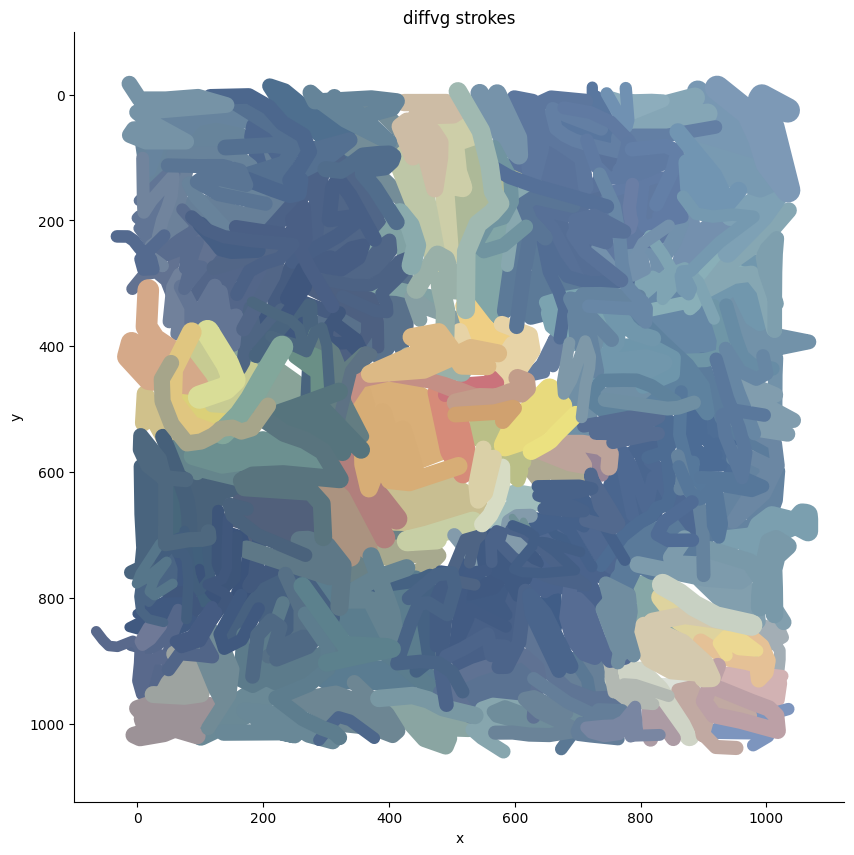

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
for stroke in diffvg_strokes:
    ax.plot(stroke["points"][:, 0], stroke["points"][:, 1], color=stroke["color"], linewidth=stroke["stroke_width"], solid_capstyle='round')
ax.invert_yaxis()
ax.set_xlim(-100, IMG_SIZE + 100)
ax.set_ylim(IMG_SIZE + 100, -100)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect("equal")
ax.set_title("diffvg strokes")
plt.show()

In [ ]:
json_strokes = []
for stroke in diffvg_strokes:
    json_strokes.append({
        "points": stroke["points"].tolist(),
        "color": stroke["color"].tolist(),
        "stroke_width": float(stroke["stroke_width"])
    })

with open(f'results/{DIR_NAME}/{DIR_NAME.split("-")[1]}_strokes_diffvg.json', 'w') as f:
    json.dump({"strokes": json_strokes}, f, indent=4)